**Author:** *Niclas Esser*

**Mail:** nesser@mpifr.mpg.de


# Introduction

In the past few years, Effelsberg is moving from analogue receiver systems to the Effelsberg Direct Digitization system (EDD), which allows the digitization directly at the receiver. Currently, Effelsberg is in the transition phase from common analogue Rx-systems to EDD-like Rx-systems. The transistion requires developments to support different scientific use cases like VLBI.

This notebook simulates the digital baseband converter 3 (DBBC3) which is used in VLBI applications. The purpose of this document is to ensure that both parties (VLBI and BDG) have the same understanding of the signal processing steps applied in the DBBC. 

Note: Software specifications and requirements for EDD-based VLBI processing will be discussed [here](../doc/software_design.pdf).

The DBBC supports 6 different operation modes

- **DDC** - Digitial Downconverter to Base Band of Independent Channels
    - DDC IQ-bands
    - DDC U/L-bands
- **OCT** - (Octopus), provides single (OCT_S) or double (OCT_D) 32-tap FIR-Filter/IF
- **DSC** - Direct Sampling Conversion
- **PFB** - Multi Equispaced Channel Conversion to Base Band Polyphase Filterbanks

whereas the digital downconverter (DDC) mode is the most common one for Effelsberg. Hence, we focus here on the DDC mode, which has the highest implementation priority.



# Digital Downconverter (DDC) Mode

The DDC is digital multi-rate processing and converts broadband signals into narrow subbands called lower and upper sidebands. The sidebands are not necessarily aligned to the original sample frequency so that the center frequency of either the lower or the upper sideband can be arbitrarily chosen. This is the desired property of the DDC mode.

## Processing Chain

The single processing steps of the DDC-mode are divided as follows.

- **Signal Generation** - Generate a signal with predefined properties.

- **Mixing** - I/Q mixer provides quadrature channels at baseband, each with upper- and lower-sidebands (USB/LSB) superimposed.

- **Resampling** - means combining interpolation (upsampling) and decimation (downsampling) to change the initial sampling rate by a rational factor.
    - **Upsampling / interpolation** is only required if the initial sampling rate is not an integer multiple of the output sampling rate
    - The low-pass or **anti-aliasing FIR** filter has a selectable bandwidth. The filter is applied before the decimation, to prevent frequencies out of the Nyquist band fold into the desired band.
    - **down-sampling** reduces the initial sample rate for the full input IF bandwidth.

- **Hilbert bandpass filtering** - advances phase 90 deg in one branch and retards 90 deg in the other. Due to the properties of the Hilbert transform, the Hilbert bandpass suppresses mirror (i.e. negative) frequencies. The result is a single band.

- **Lower and upper sideband selection** - selection occurs by the two 90 deg phase shifts causing destructive interference of one sideband and constructive interference of the other.

- ~~Fine channelization is not needed as it is applied in the VLBI correlator. However, a PFB mode can be considered for EDD if it is more efficient than implementing 16 DDC blocks.~~
The following block diagram illustrates the signal processing steps applied for the DDC mode.

| ![img](img/ddc_processing_block.png) |
|:--:|
| Block diagram of the digital downconverter personality of the DBBC. | 

The DDC expects two inputs, the digitized Rx-signal ( $x[k]$ ) and a complex oscillation with a constant frequency ( $2 \pi \cdot f_{LO} = \omega_{LO}$ ). Both inputs are mixed and then the outcome of the mixer is resampled and bandpass filtered. The output of the DDC is the lower and upper sidebands, or optionally the in-phase and quadrature components. The latter is usually used for geodetic observations.

## The DBBC3 in DDC Mode

A single DBBC3 consists of 4 ADCs and 4 FPGA each capable to operate up to 16 DDC blocks simultaneously as it is illustrated in the diagram below.

| ![img](img/dbbc_ddc.png) |
|:--:|
| DBBC3 in DDC-mode |

The output stream either L- and U-sidebands or the IQ-data are packetized by the VDIF block. The VDIF block re-quantises the data to 2-bit and appends metadata to each VDIF packet. The packets are published to the network and are subscribed by a recorder (i.e. MARK6-recorder) or possibly by a post-processor.

## Analytical Description
In the following, a more detailed description of the DDC signal processing chain is introduced.

### RF-Signal Properties
The Rx-system filters broadband signal to limit the bandwidth, for which the Rx-system is designed. Let's assume, that the Rx-system works in the second Nyquist zone. An illustration is depicted in the figure below.

| ![img](img/cartoon_afe.png) |
|:--:|
| 'Ideal' RF-Signal properties when passing the Rx-system |

The bandpass behaviour of the Rx-system reduces the anti-aliasing effects, which improves the quality when sampling the signal. If an Rx-system works in the first Nyquist zone, the bandpass is replaced by a lowpass-filer.

### Analog-Digital Conversion
As shown in the figure below, the band-limited signal within the second Nyquist zone is folded into the first Nyquist zone. Hence, we need to differentiate between the actual sky frequency and the sampled frequency.

| ![img](img/cartoon_adc.png) |
|:--:|
| Sampling the analogue signal |

As long as the sampled Nyquist zone is known, a 'reconstruction' of the original frequency is always possible. It is an interpretation of the spectrum concerning the receiver's frequency response.

### Mixing
Mixing the signal with a local oscillator (LO) shifts it to desired frequency location.

| ![img](img/cartoon_mixer.png) |
|:--:|
| Mixing the Rx-signal with an IQ-oscillator |

### Resampling

| ![img](img/cartoon_resample.png) |
|:--:|
| Resampling to desired outband bandwidth |

### Bandpassfiltering

| ![img](img/cartoon_hbp.png) |
|:--:|
| Resampling to desired outband bandwidth |

## Simulation
In this chapter, we simulate the processing chain shown in the block diagram. This simulation can be used for a digital downconversion with a fractional output sample rate as well as for an output sample rate with an integer divisor of the input sample rate. Hence, this simulation uses a general approach to achieve the digital downconversion. However, for the special case where the input data rate is an integer multiple of the output data rate, no interpolation/upsampling is involved, which effectively reduces the computing and memory resources.

Fortunately, the digitizers used for EDD systems provide an adjustable sample rate. For VLBI-modes the digitizers can be configured so that the sample ratio of the ADCs is always an integer multiple of the desired output sample ratio. For instance, if an Rx-System is designed for a bandwidth of 2 GHz and we are interested in a 128 MHz band, the ADCs sample ratio can be set to 4.096GHz. To get the 128 MHz band, only a decimation by a factor of 32 is required and the interpolation/upsampling process can be rejected.

In [ ]:
import numpy as np # Common module
import matplotlib.pyplot as plt # Plotting module
import scipy.signal as signal # Signal processing module
import math # math
import time
#%matplotlib notebook

### Signal generation
To ensure that the DDC-signal chain works as expected, we generate signals with pre-defined properties:

- duration

- samplerate

- waveform

You can chose one of the waveforms by uncomment the respective line (or add your own signal).

In [2]:
# Parameters - Sideband selection
subband_bw = 128000 # Bandwidth of the sidebands
f_lo = 4e5 # Frequency of the local oscillator
fs_out = subband_bw * 2 # Resulting sampling frequency

# Parameters - Signal properties
fs_ini = 4e6   # Sample frequency of our initial signal
sig_dur = 0.01 # Duration of the signal
t_ini = np.linspace(0,sig_dur, int(fs_ini*sig_dur)) # time vector for inital time series

# Waveforms (e.g. sin, noise or sweep/chirp), feel free to add your own
# --- sin ---
tones = [80000, 90000, 130000]#np.linspace(8e4, 1e6, 10)
#sig = np.asarray([np.sin(2 * np.pi * tone * t_ini) for tone in tones]).sum(axis=0)

# --- noise ---
#sig = np.random.normal(0,1, len(t_ini))

# --- chirp / sweep ---
f0 = 0 # Start freq of the chirp
f1 = fs_ini//4 # End freq of the chirp
t1 = sig_dur # Time to which end freq is reached
sig = signal.chirp(t_ini, f0=f0, f1=f1, t1=sig_dur)

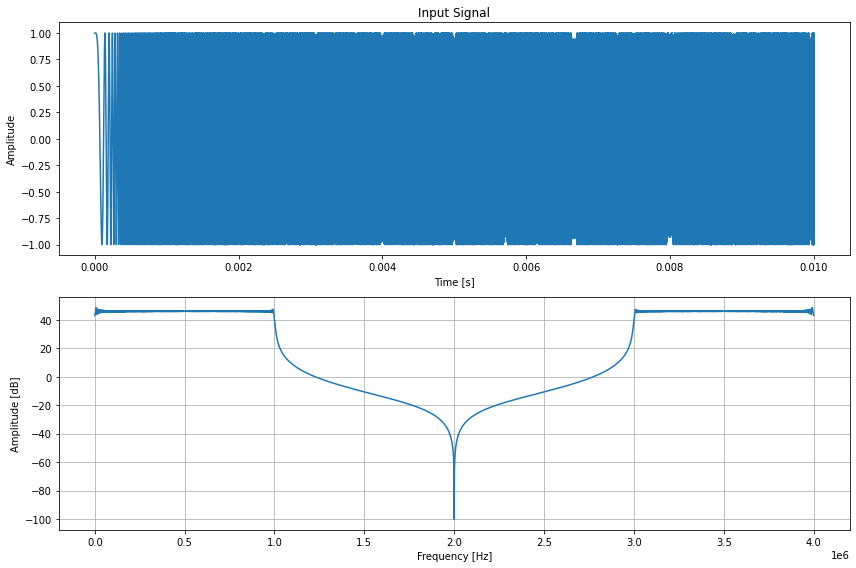

In [3]:
# X-axis for the plot
time = np.linspace(0, sig_dur, int(sig_dur * fs_ini))
freq = np.linspace(0, fs_ini, int(sig_dur * fs_ini))
# Plot the signal
fig = plt.figure(figsize=(12,8), tight_layout=True)
sub = plt.subplot(211)
sub.set_title("Input Signal")
sub.plot(time, sig)
sub.set_xlabel('Time [s]')
sub.set_ylabel('Amplitude')

sub = plt.subplot(212)
sub.plot(freq, 20*np.log10(np.abs(np.fft.fft(sig))))
sub.set_xlabel('Frequency [Hz]')
sub.set_ylabel('Amplitude [dB]')
sub.grid(which='both', axis='both')
plt.savefig("img/origin_signal.png")

### Mixing
The digitized signal is mixed with an 'local oscillator' (LO) to shift the band to the desired center frequency.

\begin{align} 
x_{mix}[k] = x[k] \cdot x_{LO}[k] = x[k] \cdot e^{-j 2\pi f_{LO} k}
\end{align}

In [4]:
lo_iq = np.exp(-2j*np.pi*f_lo*t_ini)
lo_real = np.sin(2*np.pi*f_lo*t_ini)
mixed = sig * lo_iq
#mixed_r = sig * lo_real

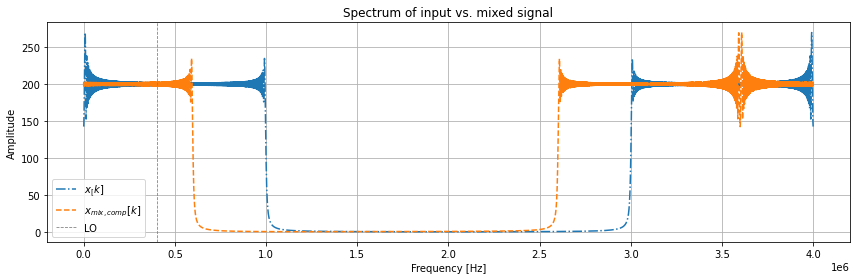

In [5]:
freq = np.linspace(0, fs_ini, int(sig_dur * fs_ini))

# Plotting
fig = plt.figure(figsize=(12,4), tight_layout=True)
plt.title("Spectrum of input vs. mixed signal")
plt.plot(freq, np.abs(np.fft.fft(sig)), linestyle='-.',label="$x_[k]$")
plt.plot(freq, np.abs(np.fft.fft(mixed)), linestyle='--', label="$x_{mix,comp}[k]$")
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.grid(which='both', axis='both')
#plt.plot(freq, np.abs(np.fft.fft(mixed_r)), linestyle=':', label="$x_{mix,real}[k]$")
plt.axvline(f_lo, label="LO", linestyle='--', linewidth=0.8, color='grey')
plt.legend()
plt.savefig("img/input_v_mixed.png")

As can be seen from the plot, the broadband signal is shifted with respect to `f_lo`

### Resampling
There are different ways to apply a resampling of a digital signal.

- Resampling by interpolation, AA-filtering, decimation (ref. diagram above)

- Resampling by polyphase filter

- Resampling by Fourier method (not implemented)

This notebook discusses the different approaches in the following subsections.


#### Approach 1: Naive Resampling
This approach uses a simple 'interpolation' by zero-padding samples to the upsampling factor. Afterwards, a lowpass filter (LPF aka anti-aliasing filter) is applied to suppress the originated high-frequency components. Lastly, samples concerning the downsampling factor are discarded.

The disadvantage of this approach is poor efficiency since more memory and computing resources are required. The reason is, that the upsampled signal with a higher data rate passes the FIR-filter, which is a very expensive task. 

In the initialization phase, we calculate up- and downsampling factors based on the least common multiplier (LCM). Note: The parameters are also valid for the other approaches.

In [6]:
lcm = np.lcm(int(fs_ini), int(fs_out))
up = int(lcm // fs_ini) # upsampling factor aka 'L'
down = int(lcm // fs_out)
fs_up = up * fs_ini
print("Upsample factor: L={}\nDownsample factor: M={}".format(up, down))

Upsample factor: L=8
Downsample factor: M=125


##### Interpolation / Upsampling
As mentioned, the interpolation process is done by zero-padding.


\begin{align}
x_{up}[n]=
\begin{cases}
x_{mix}[k] & \text{if $k\cdot L = n$} \\
0 & \text{else} \\
\end{cases} 
\text{, with } L = \frac{\text{lcm}(f_{s,in}, f_{s,out})}{f_{s,in}} \text{ and } n=0,1,2,..., K \cdot L - 1
\end{align}

In [7]:
# Upsample
sig_up = np.zeros(int(fs_up * sig_dur), dtype=complex) 
sig_up[::up] = mixed

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Plotting
freq = np.linspace(0, fs_up // 2, int(fs_up * sig_dur // 2 +1))
time = np.linspace(0, sig_dur, int(fs_up * sig_dur))

fig = plt.figure(figsize=(12,8), tight_layout=True)
sub = plt.subplot(211)
sub.plot(time, sig_up.real)
sub.plot(time, sig_up.imag)
sub.set_xlim([0, 1 / fs_up * 256]) # Zoom in
sub.set_title("Upsampled signal")
sub.set_xlabel("Time [s]")
sub.set_ylabel("Amplitude")
sub = plt.subplot(212)
sub.plot(freq, np.abs(np.fft.rfft(sig_up)))
sub.set_xlabel("Frequency [Hz]")
sub.set_ylabel("Amplitude")
sub.grid(which='both', axis='both')
plt.savefig("img/upsampled.png")

##### Lowpass / Anti-aliasing Filter
To supress the origianted high frequencies (see prev. plot), an anti-aliasing filter is applied before downsampling.


\begin{align}
x_{filt}[n] = \sum_{p=0}^{P-1} h[p] \cdot x_{up}[n-p]
\end{align}
where $h[p]$ is the function of the lowpass filter.

##### Filter design

In [9]:
# Parameters
window = "hamming"

# Calculation
max_rate = max(up, down)
f_cutoff = 1. / max_rate
ntaps = up * down * 2
fir = up*signal.firwin(ntaps, cutoff=f_cutoff, window=window)

In [10]:
# Plotting
resolution = len(fir)*8
w, h = signal.freqz(fir, worN=resolution)
freq = np.linspace(0, fs_up // 2, resolution)
fig = plt.figure(figsize=(12,8), tight_layout=True)
ax = plt.subplot(211)
ax.plot(fir)
ax.set_title("Anti-aliasing filter-coeffiecients")
ax.set_xlabel("Taps")
ax.set_ylabel("Amplitude")
sub.set_ylabel("Phase [deg]")
ax = plt.subplot(212)
ax.plot(freq[:resolution*2//down], 10*np.log10(np.abs(h[:resolution*2//down])))
ax.set_title("Frequency response")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Power [dB]")
ax.axvline(subband_bw, linestyle='--', linewidth=0.75, color="grey")
plt.savefig("img/resampled_poly.png")

##### AA-Filtering and Downsampling
After the filtering has been applied we can simply downsample the signal by discarding samples
\begin{align}
x_{down}[m] =
\begin{cases}
x_{filt}[n] & \text{if $m = \frac{n}{M}$} \\
\text{nothing} & \text{else} \\
\end{cases}\text{, with $m=0,1,2,..., K \cdot \frac{L}{M}-1$}
\end{align}

In [11]:
def naive(x, decimate, fir):
    filtered = signal.lfilter(fir, 1, x)
    return filtered[::decimate]
resampled_naive = naive(sig_up, down, fir)

#### Approach 2: Polyphase Resampling using `signal.resample_poly()`
The `scipy.signal` module provides a function called `resample_poly()` which applies a polyphase filter instead of a single FIR-Filter (anti-aliasing). The method resamples the signal by the polyphase filtering process. So, instead of the above-mentioned steps, the procedure is done by a single function call.

In [12]:
resampled_poly = signal.resample_poly(mixed, up, down)

#### Approach 3: Polyphase Decimation using own implementation


In [13]:
#%%time
def polyphase_decimation(input_data, decimate_by, filt):
    
    if len(input_data) % decimate_by != 0:
        input_data = input_data[:len(input_data)-len(input_data)%decimate_by]
        
    ntap = decimate_by
    nlen = len(input_data)//decimate_by
        
    data = input_data.reshape(nlen, ntap).T
    data[1:] = data[:0:-1]
    
    fir = filt.reshape(-1,decimate_by).T
    filtered = np.zeros((ntap, nlen+1), dtype=data.dtype)
    for i in range(decimate_by):
        filtered[i,:-1] = signal.lfilter(fir[i,:], 1, data[i,:])
    filtered[0] = np.roll(filtered[0], -1)
    return filtered.sum(axis=0)[:-1]

resampled_poly_custom = polyphase_decimation(sig_up, down, fir)

#### Comparision

As can be seen in the plots below, the three different approaches lead to nearly equal results. Hence, we assume that the three approaches are correctly implemented for this simulation.

In [14]:
# Plot
time = np.linspace(0, sig_dur, int(sig_dur * fs_out))
freq = np.linspace(f_lo-fs_out, fs_out+f_lo, int(sig_dur * fs_out))
fig = plt.figure(figsize=(12,8), tight_layout=True)
sub = plt.subplot(231)
sub.set_title("Naive Approach")
sub.set_xlabel("Time [s]")
sub.set_ylabel("Amplitude")
sub.plot(time, resampled_naive.real)
sub = plt.subplot(234)
sub.plot(freq, np.log10(np.abs(np.fft.fft(resampled_naive))))
sub.set_xlim([f_lo-fs_out, fs_out + f_lo])
sub.set_xlabel("Frequency [Hz]")
sub.set_ylabel("Amplitude  [dB]")
sub.grid(which='both', axis='both')

sub = plt.subplot(232)
sub.set_title("signal.resample_poly()")
sub.set_xlabel("Time [s]")
sub.set_ylabel("Amplitude")
sub.plot(time, resampled_poly.real)
sub = plt.subplot(235)
sub.plot(freq, np.log10(np.abs(np.fft.fft(resampled_poly))))
sub.set_xlim([f_lo-fs_out, fs_out + f_lo])
sub.set_xlabel("Freq [Hz]")
sub.set_ylabel("Amplitude  [dB]")
sub.grid(which='both', axis='both')

sub = plt.subplot(233)
sub.set_title("Polyphase decimation")
sub.set_xlabel("Time [s]")
sub.set_ylabel("Amplitude")
sub.plot(time, resampled_poly_custom.real)
sub = plt.subplot(236)
sub.plot(freq, 10*np.log10(np.abs(np.fft.fft(resampled_poly_custom))))
#sub.set_xlim([f_lo, fs_out + f_lo])
sub.set_xlabel("Freq [Hz]")
sub.set_ylabel("Amplitude [dB]")
sub.grid(which='both', axis='both')

**Execution times**

The `scipy.resample_poly` implementation outperforms the other approaches by a factor of 10 and 100, respectively. However, the own implementation of the polyphase resample shows also a performance increase of 10 times compared to the naive approach. For the implementation for parallel accelerators, the polyphase-resample strategy is a viable candidate.

In [15]:
print("Naive:") 
%timeit -n1 -r5 -o naive(sig_up, down, fir)
print("Own:")
%timeit -n1 -r5 -o polyphase_decimation(sig_up, down, fir)
print("Scipy:")
%timeit -n1 -r5 -o signal.resample_poly(mixed, up, down)

Naive:
442 ms ± 2.24 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
Own:
36.5 ms ± 360 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)
Scipy:
4.1 ms ± 268 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)


<TimeitResult : 4.1 ms ± 268 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)>

### Bandpassfiltering and Sideband Selection
As shown in the block diagram of the DDC, the last step is a bandpass filter and the sideband selection. The following two functions are used to calculate the filter coefficients and apply the actual filter and select the sidebands.

Besides the bandpass behaviour of the filter, we also want to suppress negative/mirror frequencies (see [[1]](https://www.dsprelated.com/freebooks/sasp/Hilbert_Transform_Design_Example.html) for more informations on Hilbert transform theory). 

In [16]:
def hilbert_fir(ntaps,a,w1,w2,d):
    """
    Description: Calculates filter coeffiecents for an Hilbert bandpass filter
    """
    from math import sin, cos, pi, sqrt
    output=[]

    for i in range(ntaps):
        t = 2 * pi * (i - (ntaps-1)/2)
        if(t == 0):
            o = sqrt(2)*(w2-w1)
        elif(t == pi/2*a):
            o = a*(sin(pi/4*((a+2*w2)/a))-sin(pi/4*((a+2*w1)/a)))
        elif(t == -pi/2*a):
            o = a*(sin(pi/4*((a-2*w1)/a))-sin(pi/4*((a-2*w2)/a)))
        else:
            o = 2*(pi**2)*cos(a*t)/(t*(4*(a**2)*(t**2)-pi**2))*(sin(w1*t+pi/4)-sin(w2*t+pi/4))
        output.append(o)
    if(d==1):
        output.reverse()
    return output

def apply(x, coeff_r, coeff_i):
    re = signal.lfilter(coeff_r, 1, x.real)
    im = signal.lfilter(coeff_i, 1, x.imag)
    lsb = re + im
    usb = re - im
    return lsb, usb, re, im

# Do filtering and sideband selection
h_coeff_r = hilbert_fir(301, 0.05, 0.05, 0.45,0)
h_coeff_i = hilbert_fir(301, 0.05, 0.05, 0.45,1)
lsb_naive, usb_naive, re_naive, im_naive = apply(resampled_naive, h_coeff_r, h_coeff_i)
lsb_poly, usb_poly, re_poly, im_poly = apply(resampled_poly, h_coeff_r, h_coeff_i)
lsb_poly_c, usb_poly_c, re_poly_c, im_poly_c = apply(resampled_poly_custom, h_coeff_r, h_coeff_i)

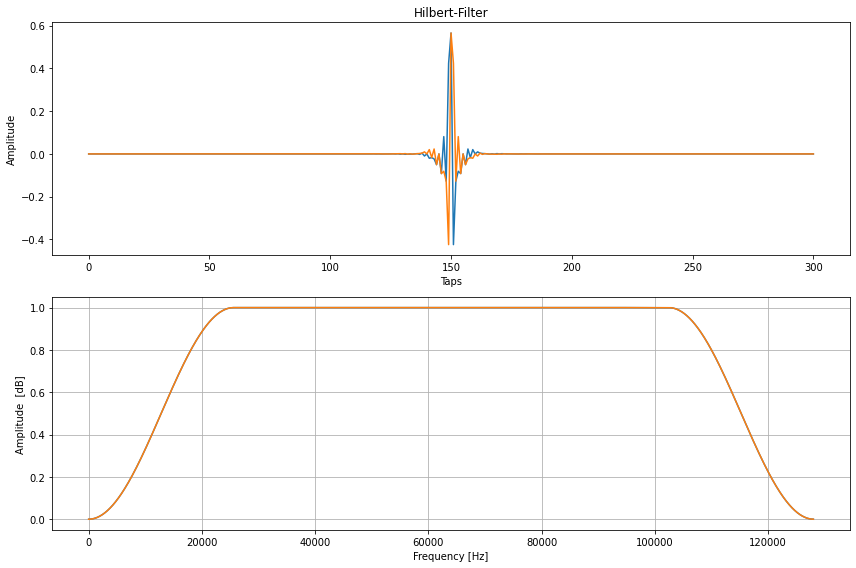

In [17]:
# Plot
resolution = len(h_coeff_r)*8
w_r, h_r = signal.freqz(h_coeff_r, worN=resolution)
w_i, h_i = signal.freqz(h_coeff_i, worN=resolution)
freq = np.linspace(0, fs_out // 2, resolution)
fig = plt.figure(figsize=(12,8), tight_layout=True)
sub = plt.subplot(211)
sub.set_title("Hilbert-Filter")
sub.set_xlabel("Taps")
sub.set_ylabel("Amplitude")
sub.plot(h_coeff_r)
sub.plot(h_coeff_i)
sub = plt.subplot(212)
sub.plot(freq, np.abs(h_r))
sub.plot(freq, np.abs(h_i))
sub.set_xlabel("Frequency [Hz]")
sub.set_ylabel("Amplitude  [dB]")
sub.grid(which='both', axis='both')

### Simulation Results

#### IQ-Results
Below are plots of the different resampling methods. All three plots look nearly identical with some minor deviation. For instance, the artefacts (small peaks) right in front and behind the band limited signals. Those artefacts occur due to the non-ideal filters applied here.

In [18]:
# Plotting
re_fft_naive = np.abs(np.fft.fft(re_naive))
im_fft_naive = np.abs(np.fft.fft(im_naive))
re_fft_poly = np.abs(np.fft.fft(re_poly))
im_fft_poly = np.abs(np.fft.fft(im_poly))
re_fft_poly_c = np.abs(np.fft.fft(re_poly_c))
im_fft_poly_c = np.abs(np.fft.fft(im_poly_c))
x_time = np.linspace(0, sig_dur, len(re_naive))
x_freq_i = np.linspace(f_lo-fs_out//2, fs_out//2+f_lo, len(re_fft_naive))
x_freq_q = np.linspace(f_lo-fs_out//2, fs_out//2+f_lo, len(re_fft_naive))

fig = plt.figure(figsize=(12,8), tight_layout=True)
sub = plt.subplot(231)
sub.plot(x_time, re_naive, label="In-phase")
sub.plot(x_time, im_naive, label="Quadrature")
sub.set_title("Naive Resample")
sub.legend()
sub = plt.subplot(232)
sub.plot(x_time, re_poly, label="In-phase")
sub.plot(x_time, im_poly, label="Quadrature")
sub.set_title("signal.resample_poly()")
sub.legend()
sub = plt.subplot(233)
sub.plot(x_time, re_poly_c, label="In-phase")
sub.plot(x_time, im_poly_c, label="Quadrature")
sub.set_title("Poly")
sub.legend()
sub = plt.subplot(234)
sub.plot(x_freq_i, re_fft_naive)
sub.plot(x_freq_q, im_fft_naive)
sub.grid(which='both', axis='both')
sub = plt.subplot(235)
sub.plot(x_freq_i, re_fft_poly)
sub.plot(x_freq_q, im_fft_poly)
sub.grid(which='both', axis='both')
sub = plt.subplot(236)
sub.plot(x_freq_i, re_fft_poly_c)
sub.plot(x_freq_q, im_fft_poly_c)
sub.grid(which='both', axis='both')
plt.savefig("img/dbbc_output.png")

#### Sidebands (LSB and USB)

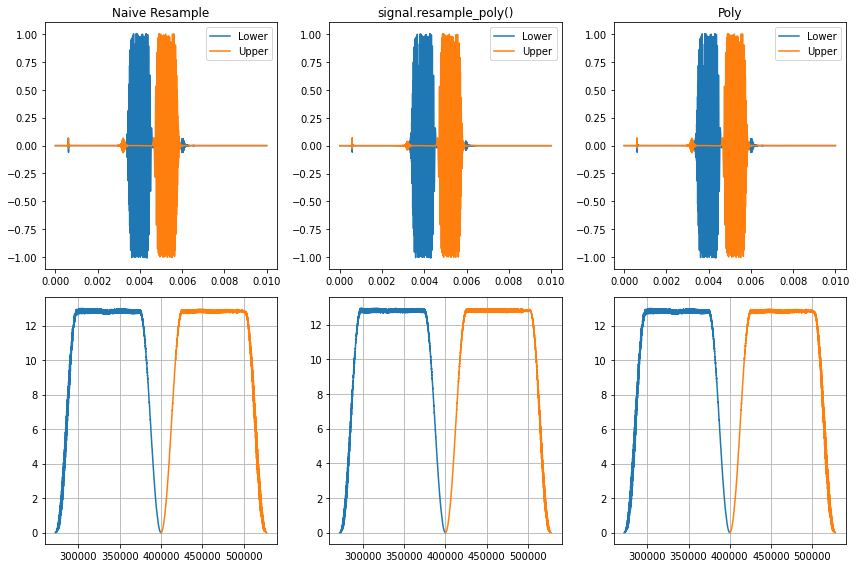

In [19]:
# Plotting
lsb_fft_naive = np.abs(np.fft.rfft(lsb_naive))
usb_fft_naive = np.abs(np.fft.rfft(usb_naive))
lsb_fft_poly = np.abs(np.fft.rfft(lsb_poly))
usb_fft_poly = np.abs(np.fft.rfft(usb_poly))
lsb_fft_poly_c = np.abs(np.fft.rfft(lsb_poly_c))
usb_fft_poly_c = np.abs(np.fft.rfft(usb_poly_c))
x_time = np.linspace(0, sig_dur, len(usb_naive))
x_freq_lsb = np.linspace(-f_lo,fs_out//2-f_lo, len(lsb_fft_naive))
x_freq_usb = np.linspace(f_lo, fs_out//2+f_lo, len(lsb_fft_naive))

fig = plt.figure(figsize=(12,8), tight_layout=True)
sub = plt.subplot(231)
sub.plot(x_time, lsb_naive, label="Lower")
sub.plot(x_time, usb_naive, label="Upper")
sub.set_title("Naive Resample")
sub.legend()
sub = plt.subplot(232)
sub.plot(x_time, lsb_poly, label="Lower")
sub.plot(x_time, usb_poly, label="Upper")
sub.set_title("signal.resample_poly()")
sub.legend()
sub = plt.subplot(233)
sub.plot(x_time, lsb_poly_c, label="Lower")
sub.plot(x_time, usb_poly_c, label="Upper")
sub.set_title("Poly")
sub.legend()
sub = plt.subplot(234)
sub.plot(-x_freq_lsb, lsb_fft_naive)
sub.plot(x_freq_usb, usb_fft_naive)
sub.grid(which='both', axis='both')
sub = plt.subplot(235)
sub.plot(-x_freq_lsb, lsb_fft_poly)
sub.plot(x_freq_usb, usb_fft_poly)
sub.grid(which='both', axis='both')
sub = plt.subplot(236)
sub.plot(-x_freq_lsb, lsb_fft_poly_c)
sub.plot(x_freq_usb, usb_fft_poly_c)
sub.grid(which='both', axis='both')
plt.savefig("img/dbbc_output.png")

### Testing Different Configurations

Let's verify our simulation by testing different configuration examples. For convenience, we set up a simple Python class which executes the proposed signal processing chain. We will use the same sweep signal from the simulation.

In [20]:
class DDC_Processor(object):
    def __init__(self, fs_in, fs_out, h_taps=301, h_a=0.05, h_w1=0.05, h_w2=0.45):
        self.fs_in = int(fs_in)
        self.fs_out = int(fs_out)
        self.subband_bw = int(fs_out // 2)
        self.lcm = np.lcm(int(fs_in), int(fs_out))
        self.up = int(self.lcm // self.fs_in)
        self.down = int(self.lcm // self.fs_out)
        print("Upsample factor: L={}\nDownsample factor: M={}".format(self.up, self.down))
        self.h_a = h_a
        self.h_w1 = h_w1
        self.h_w2 = h_w2
        self.h_taps = h_taps
        self.coeff_r = hilbert_fir(self.h_taps, self.h_a, self.h_w1, self.h_w2, 0)
        self.coeff_i = hilbert_fir(self.h_taps, self.h_a, self.h_w1, self.h_w2, 1)
    def process(self, rx_signal, f_lo):
        # When working with 'real' data streams the next four lines are obsolete. The LO-signal will be generated during the initilization
        n_samples = len(rx_signal)
        d = n_samples / self.fs_in
        t = np.linspace(0, d, n_samples)
        lo = np.exp(-2j*np.pi*f_lo*t)
        # Mixing
        x = rx_signal * lo
        # resample
        x = signal.resample_poly(x, self.up, self.down)
        # BP-filter
        self.lsb, self.usb, self.i, self.q = apply(x, self.coeff_r, self.coeff_i)
        return self.lsb, self.usb, self.i, self.q
def process_ddc(sig, fs_ini, fs_out, f_lo):
    processor = DDC_Processor(fs_ini, fs_out)
    lsb, usb, i, q = processor.process(sig, f_lo)

    # Plotting
    usb_fft = np.abs(np.fft.rfft(usb))
    lsb_fft = np.abs(np.fft.rfft(lsb))
    i_fft = np.abs(np.fft.fft(i))
    q_fft = np.abs(np.fft.fft(q))
    x_time = np.linspace(0, sig_dur, len(usb))
    x_freq_lsb = np.linspace(f_lo-fs_out//2,f_lo, len(lsb_fft))
    x_freq_usb = np.linspace(f_lo, fs_out//2+f_lo, len(usb_fft))
    x_freq_i = np.linspace(f_lo-fs_out//2, fs_out//2+f_lo, len(i_fft))
    x_freq_q = np.linspace(f_lo-fs_out//2, fs_out//2+f_lo, len(q_fft))
    if fs_out // 2 <= f_lo:
        lsb_fft = lsb_fft[::-1]
        
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    sub = plt.subplot(211)
    sub.plot(x_time, lsb, label="Lower")
    sub.plot(x_time, usb, label="Upper")
    sub.set_title("Time")
    sub.legend()
    sub = plt.subplot(212)
    sub.plot(x_freq_lsb, lsb_fft, label="Lower")
    sub.plot(x_freq_usb, usb_fft, label="Upper")
    sub.set_title("Frequency")
    sub.legend()

#### Case 1: $f_{lo} = 0$ 

In case the LO frequency is zero, one would expect that both sidebands (USB and LSB) produce the same output. Since the signal is not shifted both sidebands are sampled in the baseband from $-f_{bw}$ to $0$ and from $0$ to $f_{bw}$ containing the same information.

Note: In the time series, the band-limited signal does not start at $t = 0$. The reason is, that the output signal is delayed by the FIR structures. (Also in the following cases the time series is delayed)

Upsample factor: L=8
Downsample factor: M=125


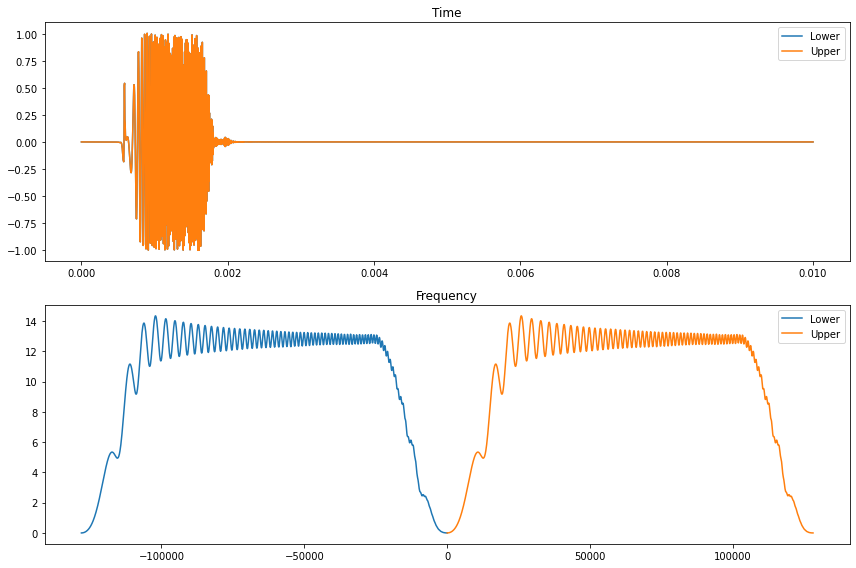

In [21]:
# Parameters - Sideband selection
subband_bw = 128000 # Bandwidth of the sidebands
f_lo = 0 # Frequency of the local oscillator
fs_out = subband_bw * 2 # Resulting sampling frequency
process_ddc(sig, fs_ini, fs_out, f_lo)

#### Case 2: $f_{LO} < bw_{sub}$

When the frequency of the local oscillator is smaller than the output bandwidth, it is expected that both sidebands overlap. The plot below shows that the lower sideband crosses the DC-bin. When mirroring the blue curve at the DC-bin both sidebands are overlapping which perfectly lines up with the presented time series. The strong oscillations at the beginning of both sidebands occur because the sweep signal used here does not have the same 'resolution' for lower frequencies. (So this is expected if we use the sweep signal)

In [22]:
# Parameters - Sideband selection
subband_bw = 128000 # Bandwidth of the sidebands
f_lo = 10000 # Frequency of the local oscillator
fs_out = subband_bw * 2 # Resulting sampling frequency
process_ddc(sig, fs_ini, fs_out, f_lo)

Upsample factor: L=8
Downsample factor: M=125


#### Case 3: $f_{LO} = f_{bw}$

When the LO-frequency is equal to the bandwidth, both bands will share an intersection at $f_{lo}$. Then the lower sideband starts always at the DC-bin.

Upsample factor: L=8
Downsample factor: M=125


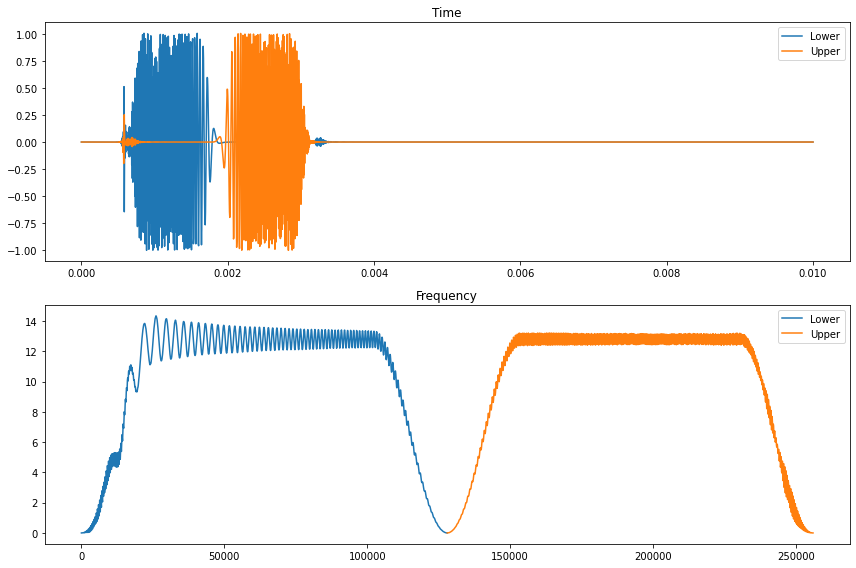

In [23]:
# Parameters - Sideband selection
subband_bw = 128000 # Bandwidth of the sidebands
f_lo = subband_bw # Frequency of the local oscillator
fs_out = subband_bw * 2 # Resulting sampling frequency
process_ddc(sig, fs_ini, fs_out, f_lo)

#### Case 4: $f_{LO} > bw_{sub}$

Both sidebands shares an intersection point by $f_{LO}$.

In [24]:
# Parameters - Sideband selection
subband_bw = 128000 # Bandwidth of the sidebands
f_lo = 6e5 # Frequency of the local oscillator
fs_out = subband_bw * 2 # Resulting sampling frequency
process_ddc(sig, fs_ini, fs_out, f_lo)

Upsample factor: L=8
Downsample factor: M=125


# ToDo:Packetization

## Re-quantization

Not simple to implement in python.

## VDIF Packing (FiLa10G)

Will also be described in [Software Design](../doc/software_design.pdf)

# Appendix
## Correspondence

### Questions & Answers (Q&A) - 1st Iteration
Does the processing chain line up with the DBBC3 processing? What is missing (except PFB)?

> Looks reasonable for the fundamentals of the DDC personality.
    Some later processing steps are (understandably) missing:
    - 2 bit thresholding
    - VDIF packetizer (FiLa10G)
    - TP counters

***

Is this processing chain applied for all DBBC3 modes?

> No, there are different processing chains for OCT, DSC, and PFB personalities, but DDC is the highest priority for early implementation.

***

Which resample-method does the DBBC3 use?

> I don't know and the details are proprietary to HAT-Lab. DBBC3 has an input sample rate that is a power-of-two MHz (1024 MHz or 2048 MHz sampler clock and use of 1, 2 or 4 sampler quadrants) and output sample rate that is a power-of-two MHz so very likely one can simply filter and decimate without re-sampling.

***

The calculation and the number of coefficients for the Hilbert filter are extracted from another program. What is the background behind it? How are the filter coefficients chosen?

>For the calculation of coefficients for the Hilbert filter I refer to a text on Hilbert transforms, eg:
https://www.dsprelated.com/freebooks/sasp/Hilbert_Transform_Design_Example.html
The number of coefficients decides the accuracy of the passband approximation to the desired
square passband.  Truncation causes ringing at the band edges, which would cause imperfect 
LSB/USB separation and likely a phase error in the visibility phase within the band.
The ringing can be reduced by applying a weighting function to the Hilbert coefficients.

>The requirement on image rejection ratio is inherited from the VLBA analogue rack, which states:
"> 26 dB over video range 10 kHz to 8 MHz" (VLBA Project Book Sec 7 IF Processing page 7-2)

>To explore the image rejection ratio and phase error dependence on truncation of the 
Hilbert transform would likely be easiest with numerical experiments. 

>For continuum VLBI where one averages over the band, I expect the ringing will cancel, so 
likely not much issue for using short Hilbert FIR filters.  For spectral line observations
where one does not average over the band, the ringing might have more impact, so weighting
the Hilbert transform will be important.
    
>From work by Ronald de Wild, ASTRON, 2020 for DBBC polarization conversion, about the Hilbert transform:

>h[n] = 2 / ( pi*(n-M) )       for  n = 1,3, … , M-3, M-1, M+1, M+3, … , 2*M-3 ,
2*M-1 (i.e. n odd)

>and

>h[n] = 0             for  n = 2,4 …        , M-2, M, M+2,       … , 2*M-4 ,
2*M-2 (i.e. n even)

>The shape of the impulse response can be controlled by weighing  h[n]  with a time-window.

>The simulation results show a comparison between “hard” truncation (i.e.
rectangular time-window – by default) and “soft” truncation (e.g. raised cosine time-window).

>Observe in the frequency response: the raised cosine window dramatically reduces
the ripple length and the ripple level, at the cost of a wider transition area.

***

Which parameters are usually specified for the sideband selection? (e.g. $f_{LO}, f_{s,out}, f_{c,low}, f_{c,up}$)

>Parameters specified:

>For each DDC:

>LO frequency (tuning resolution steps 10 kHz and 15.625 kHz)
    Phase offsets should be preserved through LO tunings, ie if LO freq is changed and 
    returned to original, the phase should return to original.

>Filter bandwidth (0.0625 MHz to 128 MHz in powers of 2)

>Select whether LSB or USB or both are to be packetized for transmission and recording.

>Select between complex or real output streams 
    complex: output the Re, Im streams after H before +/-  
    real:    output the USB, LSB streams after H and after +/-)

>Select which input receiver IF is connected to the DDC 
    Receiver might change between SFK receivers to change observing band.
    Change might happen multiple times during a VLBI experiment.

>Select total number of DDCs; specified in VEX file for backend configuration.
The number of DDCs does not change during a VLBI experiment.


## References
[1] - https://www.dsprelated.com/showarticle/176.php

[2] - https://www.mikrocontroller.net/attachment/151612/complex_signals.pdf

[3] - https://github.com/nvi-inc/vex

[4] - https://pos.sissa.it/344/140/pdf

[5] - A.R. Whitney, M. Kettenis, C. Phillips, and M. Sekido, VLBI Data Interchange Format (VDIF), in
proceedings of : 8th International e-VLBI Workshop, PoS(EXPReS09)042 (2009).